In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# for pretty printing
np.set_printoptions(4, linewidth=100, suppress=True)

----

### Image Compressing

One widely known application of SVD is image compressing. To keep things simple so that how SVD works is visually clear, let us work with a grayscale image.


In [2]:
from matplotlib.image import imread

A = imread('data/suitcase.png')

In [3]:
A.shape

(720, 1080)

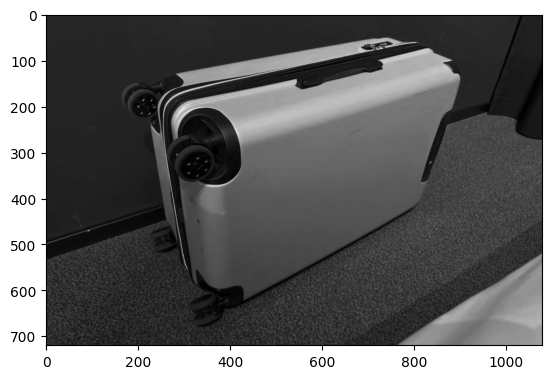

In [4]:
plt.imshow(A, cmap='gray')
plt.show()

A grayscale image of size $h \times w$ pixels can be expressed as a matrix $A \in \mathbb{R}^{h \times w}$. Following the widely used convention (which was also used last week), all entries of $A$ are within the range of $[0, 1]$ denoting the intensity of light in that pixel.

In [5]:
np.min(A), np.max(A)

(0.0, 0.9411765)

Consider the SVD $A = \sum_{i=1}^{r} \sigma_i \mathbf{u}_i \mathbf{v}_i^\top$. Each of the rank-$1$ matrices $\mathbf{u}_i \mathbf{v}_i^\top$ looks like as follows.

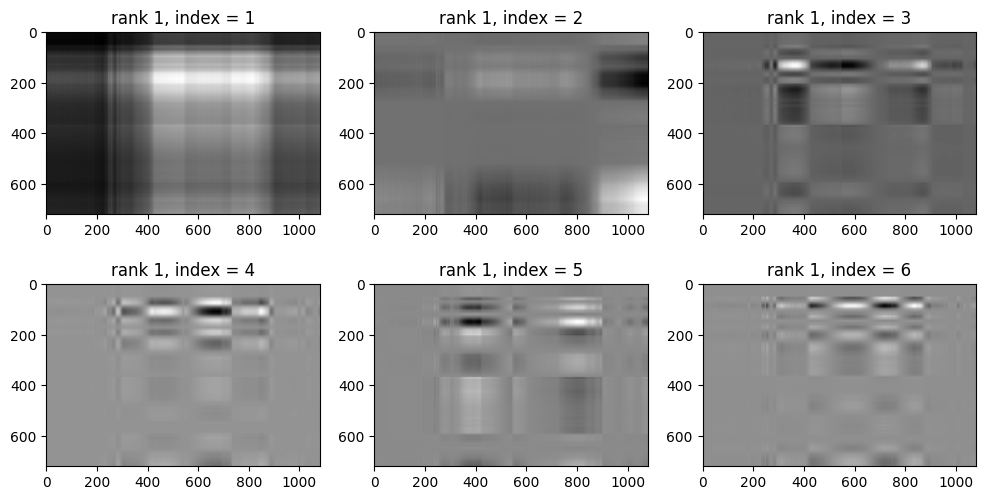

In [6]:
U, S, Vt = np.linalg.svd(A)

fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for i in range(2) :
    for j in range(3):
        idx = 3*i + j
        rnk1 = np.outer(U[:, idx], Vt[idx, :])
        ax[i, j].imshow(rnk1, cmap="gray")
        ax[i, j].set_title("rank 1, index = {}".format(idx+1))

plt.show()

Rank-$1$ matrices are too "simple" to visually tell us anything. But still, we at least can see that the rank-$1$ matrices with small indices, which are the ones that contribute the most to the SVD $A = \sum_{i=1}^r \sigma_i \mathbf{u}_i \mathbf{v}_i^\top$, try to capture the information from the areas where most variation occurs in the image. For the case of our image, that would be the center of the image, where the suitcase is located.

The best rank-$k$ approximation of $A$ is $A_k = \sum_{i=1}^k \sigma_i \mathbf{u}_i \mathbf{v}_i^\top$. Recall that $\lVert A_k \rVert_F^2 = \sigma_{1}^2 + \dots + \sigma_{k}^2$ and  $\lVert A - A_k \rVert_F^2 = \sigma_{k+1}^2 + \dots + \sigma_{r}^2$.

The *explained variance* $\frac{\lVert A_k \rVert_F^2}{\lVert A \rVert_F^2} = \frac{\sigma_1^2 + \dots + \sigma_k^2}{\sigma_1^2 + \dots + \sigma_r^2}$ measures how much information that was stored in the original data $A$ has been recovered by the low rank approximation $A_k$.

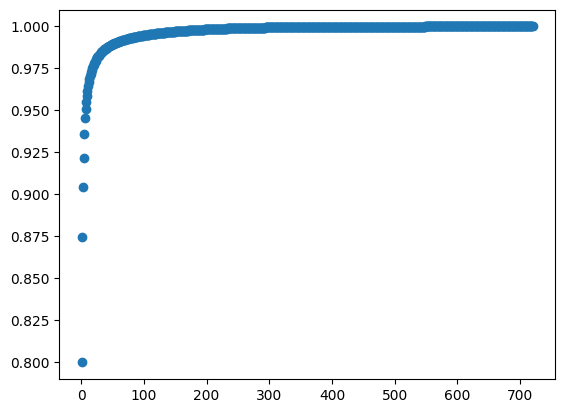

In [7]:
V = S ** 2
explained = np.cumsum(V) / np.sum(V)

fig, ax = plt.subplots()
ax.scatter(np.arange(1, 720+1),explained)
plt.show()

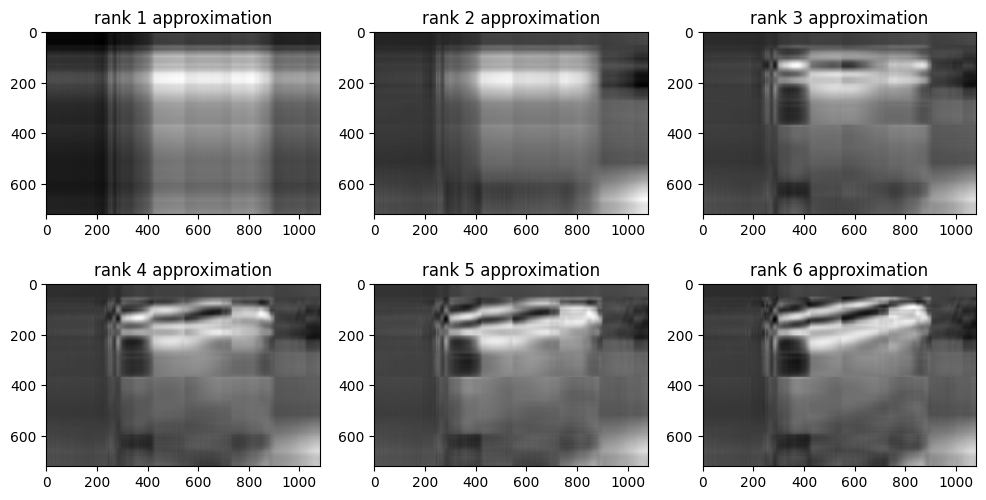

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

rnkk = np.zeros((720, 1080))

for i in range(2) :
    for j in range(3):
        idx = 3*i + j
        rnkk = rnkk + (S[idx] * np.outer(U[:, idx], Vt[idx, :]))
        ax[i, j].imshow(np.copy(rnkk), cmap="gray")
        ax[i, j].set_title("rank {} approximation".format(idx+1))

plt.show()

Let us see what is the minimum rank required to achieve a $99\%$ recovery rate.

In [9]:
idx99 = 0
for i in range(720) :
    if explained[i] > 0.99 :
        idx99 = i
        break

print(idx99)

53


Python indices start with $0$, so the above result shows that we need a rank-$\mathbf{54}$ approximation.

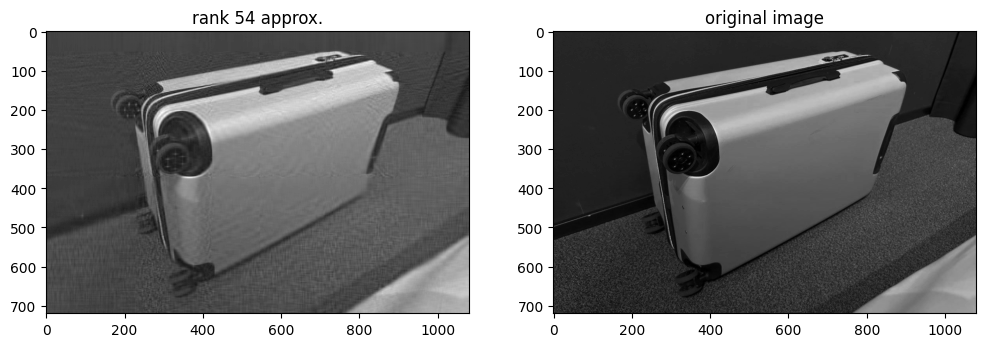

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

rnk54 = np.zeros((720, 1080))
for i in range(54) :
    rnk54 = rnk54 + (S[i] * np.outer(U[:, i], Vt[i, :]))

ax[0].imshow(np.copy(rnk54), cmap="gray")
ax[0].set_title("rank 54 approx.")
ax[1].imshow(A, cmap="gray")
ax[1].set_title("original image")

plt.show()

----

### Time Series Analysis

We now work with a yield data. In the data file, there is a matrix where each row corresponds to the weeks from 2010 to 2017, and each column represents a maturity date in the order of 3, 6, 9, 12, 18, 24, 30, 36, 60, 120, and 240 months.


In [11]:
# Some technical python code to read
# a csv file into a numpy array

fin = open("data/GovtBondWeek.csv", 'r')
header = fin.readline()
dates = []
A = []
for line in fin.readlines():
    l = line.strip().split(',')
    dates.append(l[0])
    interest = list(map(float, l[1:]))
    A.append(interest)
fin.close()

A = np.array(A)

In [12]:
A.shape

(416, 11)

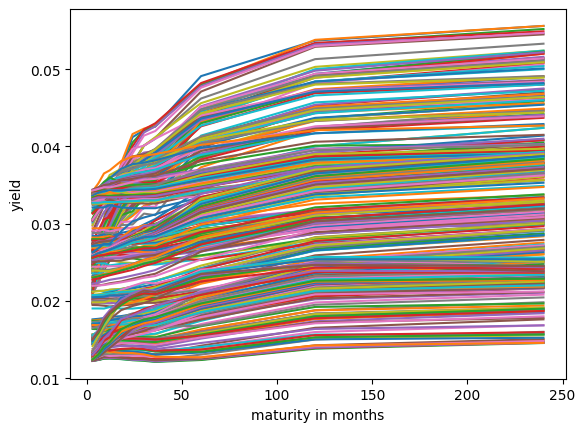

In [13]:
months = [3, 6, 9, 12, 18, 24, 30, 36, 60, 120, 240]

r_cnt, c_cnt = A.shape
fig, ax = plt.subplots()
for r in range(r_cnt):
    ax.plot(months, A[r, :])

ax.set_xlabel("maturity in months")
ax.set_ylabel("yield")
plt.show()

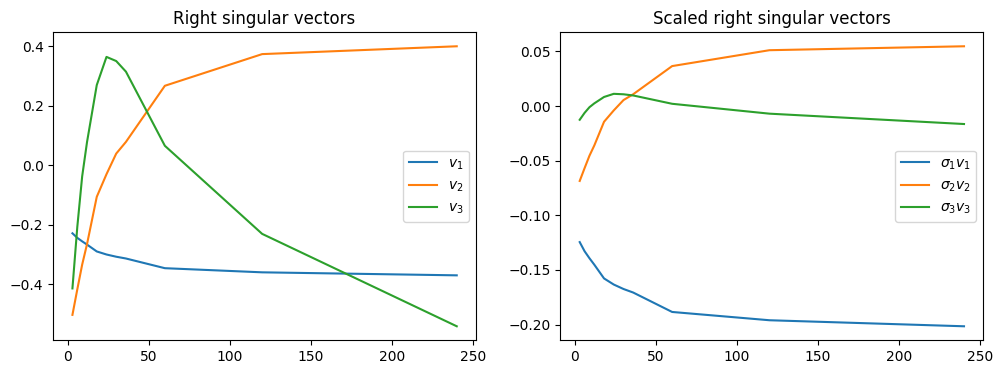

In [14]:
mu = np.mean(A, axis=0)
A = A - mu  # centering

U, S, Vt = np.linalg.svd(A)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for r in range(3):
    ax[0].plot(months, Vt[r, :], label="$v_{}$".format(r+1))

ax[0].set_title("Right singular vectors")
ax[0].legend()

for r in range(3):
    ax[1].plot(months, S[r]*Vt[r, :], label="$\sigma_{} v_{}$".format(r+1, r+1))

ax[1].set_title("Scaled right singular vectors")
ax[1].legend()

plt.show()

Because $A = \sum_{i=1}^r \sigma_i \mathbf{u}_i \mathbf{v}_i^\top = \sum_{i=1}^r \sigma_i (-\mathbf{u}_i) (-\mathbf{v}_i)^\top$, the left and right singular vectors are unique only up to a sign difference. This is why curves for $\mathbf{v}_1$ and $\mathbf{v}_2$ are upside down compared to the curves in the lectrue notes.

&nbsp;

Let $(A)_{j, :}$ denote the $j$th row of $A$, then notice that  
\begin{align*}
(A)_{j, :} = \left(\sum_{i=1}^r \sigma_i \mathbf{u}_i \mathbf{v}_i^\top\right)_{j, :} = \sum_{i=1}^r  \left(\sigma_i \mathbf{u}_i \mathbf{v}_i^\top\right)_{j, :} = \sum_{i=1}^r \sigma_i (\mathbf{u}_i)_j \mathbf{v}_i^\top.
\end{align*}

&nbsp;

With being careful that $(\mathbf{u}_i)_j$ is `U[j-1, i-1]` in NumPy, let us see how the rows of $A$ are expressed as linear combinations of the right singular vectors:

In [15]:
for j in range(4):
    coeffs = [S[i] * U[j, i] for i in range(3)]
    print("a_%d = %.4f * v_1 + %.4f * v_2 + %.4f * v_3 + ..." \
          %(j+1, coeffs[0], coeffs[1], coeffs[2]))

a_1 = -0.0477 * v_1 + 0.0160 * v_2 + 0.0032 * v_3 + ...
a_2 = -0.0476 * v_1 + 0.0157 * v_2 + 0.0033 * v_3 + ...
a_3 = -0.0465 * v_1 + 0.0153 * v_2 + 0.0025 * v_3 + ...
a_4 = -0.0466 * v_1 + 0.0152 * v_2 + 0.0026 * v_3 + ...


Following our lecture notes, let us interpret the result from above as
\begin{align*}
(A)_{j, :} = L_j \mathbf{v}_1 + S_j \mathbf{v}_2 + C_j \mathbf{v}_3 + \textsf{(noise)}.
\end{align*}

Let us plot how the values of $L_j$, $S_j$, and $C_j$ has evolved over time.

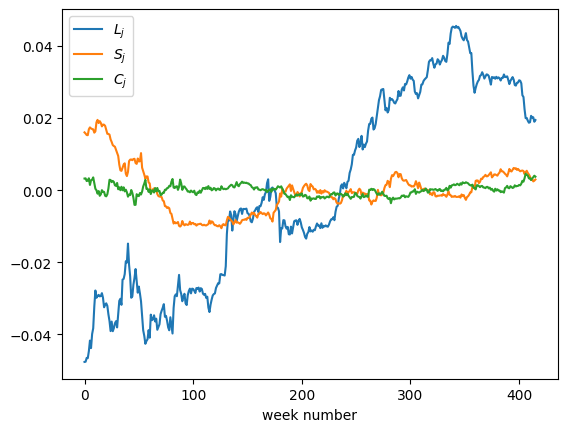

In [16]:
fig, ax = plt.subplots()

# L_j = S[0] * U[j, 0]
ax.plot(np.arange(416), S[0] * U[:, 0], label="$L_j$")

# similarly...
ax.plot(np.arange(416), S[1] * U[:, 1], label="$S_j$")
ax.plot(np.arange(416), S[2] * U[:, 2], label="$C_j$")

ax.set_xlabel("week number")
ax.legend()
plt.show()

Be careful: the value of $L_j$ has *increased* over time, but from the plot above we can observe that $\mathbf{v}_1$, which acts as a level curve, is a vector of **negative** values. So, one should conclude that the overall level of the yield has **decreased** over time.